<a href="https://colab.research.google.com/github/mdzahid80/Basics/blob/master/Sentiment_Analyser_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text Classification Using Spacy Word Embeddings**
Problem Statement
Sentiments analysis based twitter tweets done near elections


We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is positive, negative or neutral.

We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.

Dataset
Credits:https://www.kaggle.com/datasets/rishabhvyas/indian-election-tweets
.

This data consists of two columns. - Text - label

Text is the statements or messages regarding a particular event/situation.

label feature tells whether the given text is Negative or Positive.

As there are only 2 classes, this problem comes under the Binary Classification.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import pickle
import re

In [ ]:
%pip install wordcloud

In [ ]:
data1 = pd.read_csv(r"/content/bjp_tweets.csv")
data2 = pd.read_csv(r"/content/congress_tweets.csv")

print(f"Dataset shape : {data2.shape}")

Dataset shape : (30252, 2)


In [ ]:
print(f"Feature names for data 1: {data1.columns.values}")
print(f"Feature names for data 2: {data2.columns.values}")

Feature names for data 1: ['tweet' 'target']
Feature names for data 2: ['tweet' 'target']


In [ ]:
data=pd.concat([data1,data2])

In [ ]:
#Check for null values
data.isnull().sum()

tweet     0
target    0
dtype: int64

In [ ]:
#Getting the record where 'target' is null

data[data['target'].isna() == True]

,tweet,target


In [ ]:
#We will drop the null record

data.dropna(inplace=True)

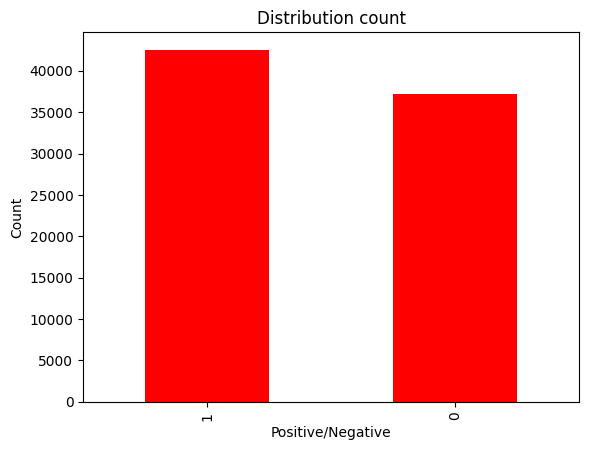

In [ ]:
#Bar plot to visualize the total counts of each sentiments

data['target'].value_counts().plot.bar(color = 'red')
plt.title('Distribution count')
plt.xlabel('Positive/Negative')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Sentiment value count - percentage distribution: \n{round(data['target'].value_counts()/data.shape[0]*100,2)}")

Sentiment value count - percentage distribution: 
target
1    53.34
0    46.66
Name: count, dtype: float64


###Let's plot the above values in a pie chart

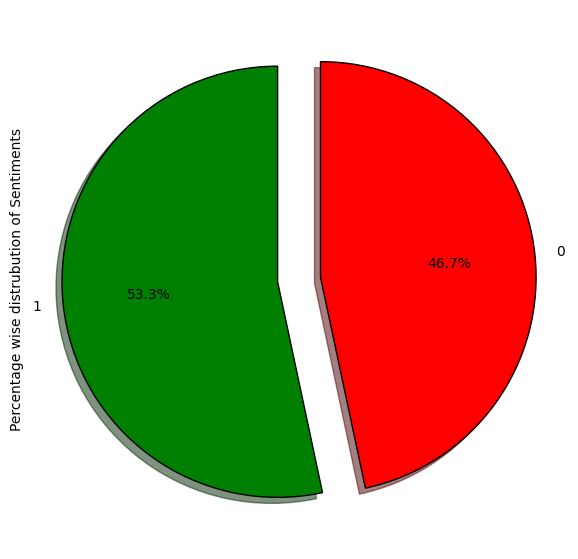

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('green','red')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['target'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of Sentiments')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'Tweet' column
This column refers to the feedback of the verified review

In [ ]:
#Distinct values of 'feedback' and its count

print(f"Tweet value count: \n{data['target'].value_counts()}")

Tweet value count: 
target
1    42527
0    37202
Name: count, dtype: int64


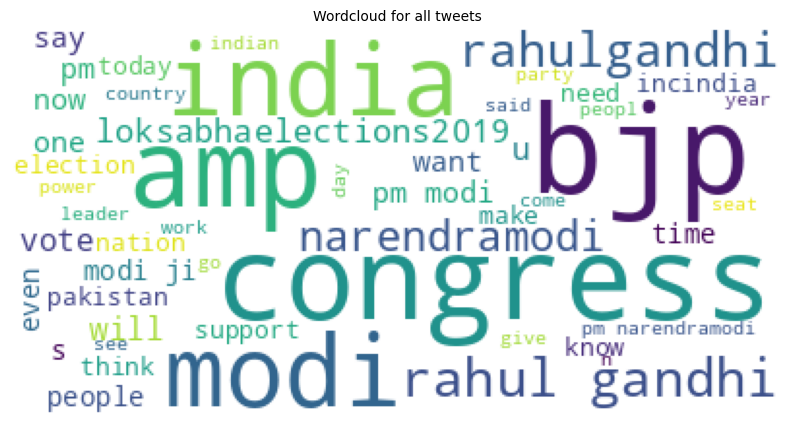

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['tweet']])

# Initializing wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud for our tweets in datasets
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all tweets', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
#Add the new column which gives a unique number to each of these labels
data['target_value'] = data['target'].map({ 0 :'Negative', 1 : 'Positive'})

#check the results with top 5 rows
data.head(5)

,tweet,target,target_value
0,ndtv anchor let go over to aap live press conf...,0,Negative
1,sambit patra attacks rahul gandhi over his cow...,0,Negative
2,crediting the bjp with taking development to s...,1,Positive
3,ktrbrs do do false allegations on iasassociati...,0,Negative
4,gujarat assembly yet to get rs cr as gst compe...,1,Positive


In [ ]:
data.shape

(79729, 3)

In [ ]:
# because our dataset has 73960 rows, machine is incomaptiable so we are using some random parts of dataset to train
temp1=data[data.target==1].sample(4000)
temp2=data[data.target==0].sample(4000)

In [ ]:
df=pd.concat([temp1,temp2],axis=0)
df.shape

(8000, 3)

In [ ]:
df.columns

Index(['tweet', 'target', 'target_value'], dtype='object')

**Get spacy word vectors and store them in a pandas dataframe**

Downloading English Core medium model for Spacy model

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

In [ ]:
df['vector'] = df['tweet'].apply(lambda text: nlp(text).vector)

Now We have Vectorized form for our tweets which will be used to train and test our model using datasets

In [ ]:
df.head()

,tweet,target,target_value,vector
23069,modi everyth parent taught via thewirein,1,Positive,"[-0.63363, -1.12942, -0.5523533, -1.02576, 1.9..."
15351,modi elect gave congress year give bjp month c...,1,Positive,"[-0.7555663, 1.2004825, -1.0448349, -0.4178426..."
24139,we can make pm from bjp next time but not now ...,1,Positive,"[1.6878228, 2.7331667, -2.1395102, -1.0570774,..."
46719,divyaspandana narendramodi bhade p bulaye gye ...,1,Positive,"[-0.3312043, 1.7560643, -1.3020834, -0.2021111..."
794,the real fact open the eyes asadowaisi fanofow...,1,Positive,"[-0.18574093, 2.0444, 0.10739818, 1.0800166, 3..."


Using SKLearn Train-Test-Split method to create our dataset which will be used for training our model, where test size is 0.2 which means we will take 80% for training and left 20% for testing

'X' here shows the input we will be getting which here is vector of tweets and the 'y'is the result we want which here is target which shows Positive/Negative for a string


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.target,
    test_size=0.2
)

As our model needs 2D data for training we will use stack function to convert it into 2D array format

In [ ]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
# Using Multinomial Naive Bayes Classifier to train model
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score



scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

Creating a Clssification report of our model

In [ ]:

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.64      0.64       793
           1       0.64      0.65      0.65       807

    accuracy                           0.64      1600
   macro avg       0.64      0.64      0.64      1600
weighted avg       0.64      0.64      0.64      1600



In [ ]:
predictions = clf.predict(X_test_2d)
accuracy = accuracy_score(y_test, predictions)
accuracy
print("Accuracy:", accuracy)


Accuracy: 0.50625


In [ ]:
from  sklearn.neighbors import KNeighborsClassifier

# 1. creating a KNN model
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fitting with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. getting the predictions for all_test_embeddings and storing data in y_pred
y_pred = clf.predict(X_test_2d)

clf


KNeighborsClassifier(metric='euclidean')

In above we see KNN has more precision than NaiveBayes soo we will be using KNN

In [ ]:
#4. print the classfication report of KNN model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       793
           1       0.69      0.58      0.63       807

    accuracy                           0.66      1600
   macro avg       0.66      0.66      0.66      1600
weighted avg       0.66      0.66      0.66      1600



In [ ]:
predictions = clf.predict(X_test_2d)
accuracy = accuracy_score(y_test, predictions)
accuracy
print("Accuracy:", accuracy)


Accuracy: 0.6575


Text(95.72222222222221, 0.5, 'Truth')

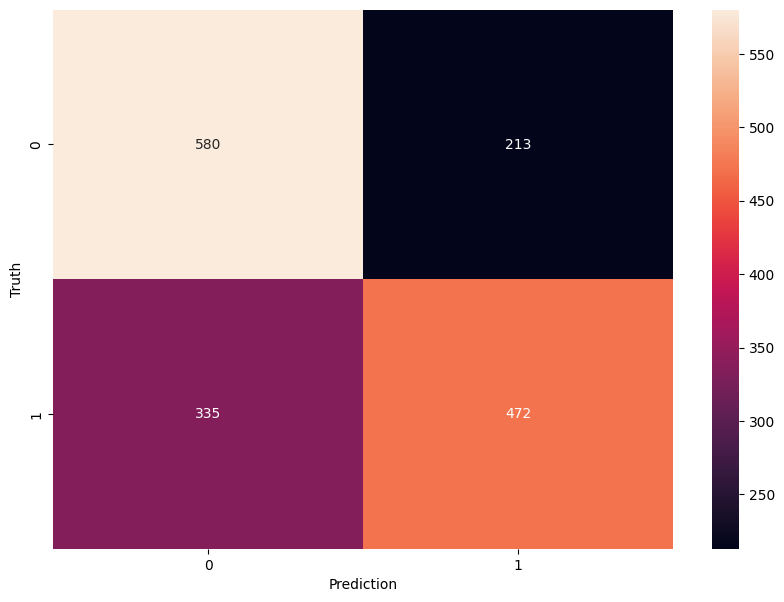

In [ ]:
# Creating A confusion matrix for my KNN model which has more precision
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')


exporting our KNN model using Pickle

The KNN model will be used for my Flask application.

In [ ]:
pickle.dump(nlp, open('/content/nlp.pkl', 'wb'))

In [ ]:
pickle.dump(cm, open('/content/knn_model.pkl', 'wb'))

Converting my Colab file to PDF

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/Sentiment_Analyser_Model.ipynb

In [ ]:
x="He will kill rahul or modi"
y=nlp(x).vector
clf.predict([y])

array([0])

In [ ]:
x="I Love rahul & modi"
y=nlp(x).vector
clf.predict([y])

array([1])

In [ ]:
x="He is going to do blast"
y=nlp(x).vector
clf.predict([y])

array([0])

In [ ]:
x="He is planning a riot"
y=nlp(x).vector
clf.predict([y])

array([0])

In [ ]:
x="He is our Protector"
y=nlp(x).vector
clf.predict([y])

array([0])

In [ ]:
x="He will protect us"
y=nlp(x).vector
clf.predict([y])

array([1])

In [ ]:
x="Police is there for protection of voter"
y=nlp(x).vector
clf.predict([y])

array([0])